# Code

In [1]:
import pandas as pd
import os
import time
import numpy as np
import sys
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '..')
import dataset.preprocessing as utils
from config import *

### Pre-processing

In [2]:
human_annotations = utils.read_dataframe(os.path.join(original_files_dir, 'annotation_by_biomaRt_hs.txt'), columns_to_drop = ['Unnamed: 0', 'transcript_biotype', 'external_gene_name', '5utr', '3utr', 'cds', 'ID'])
mouse_annotations = utils.read_dataframe(os.path.join(original_files_dir, 'annotation_by_biomaRt_mm.txt'), columns_to_drop = ['Unnamed: 0', 'transcript_biotype', 'external_gene_name', '5utr', '3utr', 'cds', 'ID'])
annotations = pd.concat([human_annotations, mouse_annotations], axis = 0)
annotations['protein_coding'] = False
annotations.loc[ annotations['gene_biotype'] == 'protein_coding', 'protein_coding'] = True

In [3]:
info = utils.read_dataframe(os.path.join(original_files_dir, 'index_bio_regions.Tx.RI_ALL.txt'), columns_to_drop = ['Unnamed: 0'])

In [4]:
filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.no_cds_cds.bedpe')

rows = []
with open(filename)as f:
    for line in f:
        L = line.strip().split()
        rows.append(L)
        
all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )

#they are already mapped so the strand should be always '+'
assert (all_interactions.strand1 == all_interactions.strand2).all()
assert set(all_interactions.strand1) == {'+'}

all_interactions = all_interactions.filter(['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'experiment', 'name'], axis = 1)

all_interactions[['x1', 'x2', 'y1', 'y2']] = all_interactions[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)

In [6]:
merged = all_interactions.merge(info, on = 'name')

assert (merged.tr1 == merged.chrom_1).all()
assert (merged.tr2 == merged.chrom_2).all()
assert (merged.x1 == merged.start_1).all()
assert (merged.x2 == merged.end_1).all()
assert (merged.y1 == merged.start_2).all()
assert (merged.y2 == merged.end_2).all()
assert (merged.strand_1 == merged.strand_2).all()
assert set(merged.strand_1) == {'+'}

merged = merged.drop(['chrom_1', 'chrom_2', 'start_1', 'end_1', 'start_2', 'end_2', 'strand_1', 'strand_2',
             'score', 'external_gene_name_1', 'external_gene_name_2', 'chrom_1_localization', 'chrom_2_localization', 
            'gene_biotype_1', 'gene_biotype_2'], axis = 1)

In [7]:
ann = annotations[['ensembl_gene_id', 'ensembl_transcript_id', 'length', 'protein_coding']]

merged = merged.merge(ann, left_on = 'tr1', right_on = 'ensembl_transcript_id').rename(
{'ensembl_gene_id':'gene1', 'length': 'length1', 'protein_coding':'protein_coding1'}
, axis = 1)

merged = merged.drop(['ensembl_transcript_id'], axis = 1)

merged = merged.merge(ann, left_on = 'tr2', right_on = 'ensembl_transcript_id').rename(
{'ensembl_gene_id':'gene2', 'length': 'length2', 'protein_coding':'protein_coding2'}
, axis = 1)

merged = merged.drop(['ensembl_transcript_id'], axis = 1)

assert (merged.ensembl_gene_id_1 == merged.gene1).all()
assert (merged.ensembl_gene_id_2 == merged.gene2).all()
merged = merged.drop(['ensembl_gene_id_1','ensembl_gene_id_2', 'name'], axis = 1)

In [8]:
all_transcript_ids = set(merged.tr1).union(merged.tr2)
all_gene_ids = set(merged.gene1).union(merged.gene2)
annotations = annotations[annotations.ensembl_transcript_id.isin(all_transcript_ids)]
assert annotations.shape[0] == len(all_transcript_ids)
assert set(annotations.ensembl_gene_id) == all_gene_ids
assert set(annotations.ensembl_transcript_id) == all_transcript_ids

In [9]:
annotations = annotations.rename({'ensembl_gene_id':'gene_id'}, axis = 1)

annotations.loc[ annotations['UTR5'] == '/', 'UTR5'] = np.nan
annotations.loc[ annotations['CDS'] == '/', 'CDS'] = np.nan
annotations.loc[ annotations['UTR3'] == '/', 'UTR3'] = np.nan

assert annotations[annotations['UTR3'].isna()]['UTR5'].isna().all()
assert annotations[annotations['UTR3'].isna()]['CDS'].isna().all()
assert annotations[annotations['UTR5'].isna()]['CDS'].isna().all()

annotations[['UTR3', 'UTR5', 'CDS']] = annotations[['UTR3', 'UTR5', 'CDS']].apply(pd.to_numeric)

species = pd.concat([
    merged[['tr1', 'specie']].rename({'tr1':'ensembl_transcript_id'}, axis = 1),
    merged[['tr2', 'specie']].rename({'tr2':'ensembl_transcript_id'}, axis = 1)
], axis = 0).drop_duplicates().reset_index(drop = True)

merged = merged.drop(['specie'], axis = 1)

annotations = annotations.merge(species)

annotations.loc[ annotations['specie'] == 'hs', 'specie'] = "{'hs'}"
annotations.loc[ annotations['specie'] == 'mm', 'specie'] = "{'mm'}"

annotations = annotations.rename({'specie':'species_set'}, axis = 1)

assert len(annotations.gene_id.unique()) == len(annotations.ensembl_transcript_id.unique()) == annotations.shape[0]
assert set(merged.tr1).union(merged.tr2) == set(annotations.ensembl_transcript_id)
assert set(merged.gene1).union(merged.gene2) == set(annotations.gene_id)

In [10]:
merged = merged.rename({'gene1':'gene_id1', 'gene2':'gene_id2'}, axis = 1)

merged[['couples', 'need_to_swap']] = merged[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)

def swap_genes_if_needed(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
    df.loc[where, ['length1', 'length2']] = (df.loc[where, ['length2', 'length1']].values)
    df.loc[where, ['tr1', 'tr2']] = (df.loc[where, ['tr2', 'tr1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df.loc[where, ['protein_coding1', 'protein_coding2']] = (df.loc[where, ['protein_coding2', 'protein_coding1']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    n_duplicates = original_dim - df.shape[0] 
    print(f"{n_duplicates} interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)")
    return df

merged = swap_genes_if_needed(merged)

0 interactions were duplicated (the genes were swopped, now they have a unique couples_id so I can see only now that they are duplicated)


In [19]:
merged['w'] = merged['x2'] - merged['x1']
merged['h'] = merged['y2'] - merged['y1']
merged = merged.drop(['tr1', 'tr2', 'y2', 'x2'], axis = 1).rename(
    {'gene_id1':'gene1', 'gene_id2':'gene2', 
     'protein_coding1':'protein_coding_1', 'protein_coding2':'protein_coding_2',
     'length1':'length_1', 'length2':'length_2',
    }, axis = 1)

merged['interacting'] = True

merged = merged[['couples', 'gene1', 'gene2', 'interacting', 'length_1', 'length_2', 
                 'protein_coding_1', 'protein_coding_2', 'x1', 'y1', 'w', 'h', 'experiment']]

In [20]:
map_name = {'ricseq': 'hs_RIC-seq__HeLa_merge.InterGene.arms', 'mario':'mm_MARIO__mES'}

ricseq = merged[merged.experiment == map_name['ricseq']].drop('experiment', axis = 1).reset_index(drop = True)
mario = merged[merged.experiment == map_name['mario']].drop('experiment', axis = 1).reset_index(drop = True)

### Clean bounding boxes of df interactions

In [12]:
how = 'mario'
assert how in ['ricseq', 'mario']

In [75]:
if how=='ricseq':
    int_or = ricseq
    
elif how == 'mario':
    int_or = mario

    
#36 min ricseq
diz_int = {}
idx = 0
for couple in tqdm(int_or.couples.unique()):
    subset = int_or[int_or.couples == couple]
    list_of_boxes = subset.filter(['x1', 'y1', 'w', 'h']).values.tolist()
    new_list_of_boxes = utils.clean_bounding_boxes(list_of_boxes)
    row = int_or[int_or.couples == couple].iloc[0]
    for box in new_list_of_boxes:
        d = dict(row)
        d['x1'] = box[0]
        d['y1'] = box[1] 
        d['w'] = box[2]
        d['h'] = box[3]
        diz_int[idx] = d
        idx+=1
df_int = pd.DataFrame.from_dict(diz_int, 'index').rename({'gene_id1':'gene1', 'gene_id2':'gene2'}, axis = 1)

if how=='ricseq':
    int_or = ricseq
    
elif how == 'mario':
    int_or = mario

  0%|          | 0/990 [00:00<?, ?it/s]

In [76]:
assert len(int_or.couples.unique()) == len(df_int.couples.unique())
print(f'#interazioni prima {int_or.shape[0]}, #interazioni dopo: {df_int.shape[0]}')
df_int.to_csv(os.path.join(processed_files_dir, f'full_{how}_info_interactions.csv'), index = False)

#interazioni prima 993, #interazioni dopo: 993


### Now I have to create negatives

In [11]:
how = 'ricseq'

In [12]:
ricseq = pd.read_csv(os.path.join(processed_files_dir, f'full_ricseq_info_interactions.csv'))
mario = pd.read_csv(os.path.join(processed_files_dir, f'full_mario_info_interactions.csv'))

In [13]:
def order_genes(x):
    x1, x2 = x.split('_')
    return utils.get_couple_id(x1, x2)

In [14]:
if how=='ricseq':
    df_pairs_full = ricseq[['couples','gene1', 'gene2']].rename({'couples':'positive'}, axis = 1)
    
elif how == 'mario':
    df_pairs_full = mario[['couples','gene1', 'gene2']].rename({'couples':'positive'}, axis = 1)

In [15]:
how_many_negatives_per_positive = 2 

for i in range(how_many_negatives_per_positive):
    df_pairs_full['gene2'] = df_pairs_full.sample(frac=1, replace=False, random_state=42).reset_index(drop = True)['gene2']
    df_pairs_full[f'negative{i}'] = df_pairs_full['gene1'] + '_' + df_pairs_full['gene2']
    
df_pairs_full = pd.concat([
    df_pairs_full[['positive', 'negative0']].rename({'negative0':'negative'}, axis = 1),
    df_pairs_full[['positive', 'negative1']].rename({'negative1':'negative'}, axis = 1)
], axis = 0)

df_pairs_full['negative'] = df_pairs_full['negative'].apply(order_genes)
df_pairs_full['positive'] = df_pairs_full['positive'].apply(order_genes)

In [16]:
to_drop = set(df_pairs_full['positive']).intersection(df_pairs_full['negative'])

print('how many to drop', len(to_drop))

df_pairs_full = df_pairs_full[~df_pairs_full['negative'].isin(to_drop)]

print(f'We have {len(set(df_pairs_full.positive))} pairs interacting (they can have multiple interactions) \n')
print(f'We have {len(set(df_pairs_full.negative))} pairs not interacting \n')

how many to drop 10701
We have 88105 pairs interacting (they can have multiple interactions) 

We have 167254 pairs not interacting 



#### Drop all the negative interactions that are seen positive in the other experiments

In [17]:
prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)

print('how many to drop', len(df_pairs_full[df_pairs_full.negative.isin(prohibited_couples['id'])]))

df_pairs_full = df_pairs_full[~df_pairs_full.negative.isin(prohibited_couples['id'])].reset_index(drop = True)

how many to drop 1128


In [11]:
if how == 'ricseq':
    df_pairs_full.to_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_RICSEQ.csv'), index = False)
elif how == 'mario':
    df_pairs_full.to_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_MARIO.csv'), index = False)

#### Create fake negative interactions

In [18]:
if how == 'ricseq':
    df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_RICSEQ.csv'))
    df_int1 = ricseq[['gene1', 'x1', 'w']].rename({'gene1':'gene', 'x1':'c1',  'w': 'l'}, axis = 1)
    df_int2 = ricseq[['gene2', 'y1', 'h']].rename({'gene2':'gene', 'y1':'c1',  'h': 'l'}, axis = 1)
    df_int = ricseq[['couples', 'gene1', 'gene2', 
                 'interacting', 'length_1', 'length_2',
                 'protein_coding_1', 'protein_coding_2',
                 'x1', 'y1', 'w', 'h']]
elif how == 'mario':
    df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_MARIO.csv'))
    df_int1 = mario[['gene1', 'x1', 'w']].rename({'gene1':'gene', 'x1':'c1', 'w': 'l'}, axis = 1)
    df_int2 = mario[['gene2', 'y1', 'h']].rename({'gene2':'gene', 'y1':'c1', 'h': 'l'}, axis = 1)
    df_int = mario[['couples', 'gene1', 'gene2', 
                 'interacting', 'length_1', 'length_2',
                 'protein_coding_1', 'protein_coding_2',
                 'x1', 'y1', 'w', 'h']]
    
df_coord = pd.concat([df_int1, df_int2], ignore_index = True)#.drop_duplicates().reset_index(drop = True)
#df_coord may have duplicates. but this is something I want. If a gene appears more than once, I want it to be sampled according to its distribution.

In [19]:
df_neg = df_pairs_full[['negative']].drop_duplicates().reset_index(drop = True)
df_neg[['gene1', 'gene2']] = df_neg['negative'].str.split('_', expand = True)
df_neg = df_neg.rename({'negative':'couples'}, axis = 1)

df_neg['interacting'] = False
df_neg = df_neg.merge(annotations[['gene_id', 'length', 'protein_coding']], left_on = 'gene1', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_1','protein_coding':'protein_coding_1'} , axis = 1)
df_neg = df_neg.merge(annotations[['gene_id', 'length', 'protein_coding']], left_on = 'gene2', right_on = 'gene_id').drop('gene_id', axis = 1).rename({'length': 'length_2','protein_coding':'protein_coding_2'} , axis = 1)

In [20]:
assert set(df_neg.gene1).union(set(df_neg.gene2)) - set(df_coord.gene) == set()
df_coord = df_coord.merge(
    annotations.filter(['gene_id', 'UTR5', 'CDS', 'UTR3', 'protein_coding'], axis = 1).rename({'gene_id':'gene'}, axis = 1)
)
df_coord['where_c1'] = df_coord.apply(utils.where_interacts, axis = 1)

In [ ]:
# mario: 0.5 min
# ricseq: min
start_time = time.time()
new_cols = df_neg[['couples', 'gene1', 'gene2']].apply(utils.create_fake_coord_neg, axis = 1, args = (df_coord,df_pairs_full,df_int,))
print(f"Total time: {(time.time()-start_time)/60} minutes")

In [ ]:
new_cols = new_cols.apply(pd.Series).rename({0:'x1', 1:'y1', 2:'w', 3:'h'}, axis = 1)
df_neg = pd.concat([df_neg, new_cols], axis = 1)
df = pd.concat([df_int, df_neg], ignore_index = True, axis = 0)

In [ ]:
if how =='ricseq':
    df.to_csv(os.path.join(processed_files_dir, f'final_{how}_RANDOM_FULL.csv'), index = False)
    
else:
    df.to_csv(os.path.join(processed_files_dir, f'final_{how}_RANDOM.csv'), index = False)

In [ ]:
annotations.to_csv(os.path.join(processed_files_dir, f'df_genes_mario_ricseq.csv'), index = False)

### CREIAMO UNA VERSIONE DI ALTA QUALITA PER RICSEQ, IN CUI I POSITIVI SONO SUPPORTATI DA ALMENO 2 READS


In [2]:
how = 'ricseq'

In [6]:
df = pd.read_csv(os.path.join(processed_files_dir, f'final_{how}_RANDOM_FULL.csv'))

def swap_genes_if_needed(df):
    original_dim = df.shape[0]
    where = df.need_to_swap
    df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df = df.drop('need_to_swap', axis = 1)
    df = df.drop_duplicates().reset_index(drop = True)
    n_duplicates = original_dim - df.shape[0] 
    return df

if how == 'ricseq':
    filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.no_cds_cds.bedpe')

    rows = []
    with open(filename)as f:
        for line in f:
            L = line.strip().split()
            rows.append(L)

    all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
    all_interactions['n_reads'] = all_interactions['n_reads'].apply(pd.to_numeric)
    all_interactions = all_interactions[all_interactions['experiment'] == 'hs_RIC-seq__HeLa_merge.InterGene.arms']
    all_interactions = all_interactions[all_interactions.n_reads>1]

    merged = all_interactions.merge(info, on = 'name')
    merged = merged[['ensembl_gene_id_1', 'ensembl_gene_id_2', 'x1', 'x2', 'y1', 'y2']].rename({'ensembl_gene_id_1':'gene_id1', 'ensembl_gene_id_2':'gene_id2'}, axis = 1)
    merged[['couples', 'need_to_swap']] = merged[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)
    merged = swap_genes_if_needed(merged)
    merged[['x1', 'x2', 'y1', 'y2']] = merged[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)
    merged['w'] = merged['x2'] - merged['x1'] 
    merged['h'] = merged['y2'] - merged['y1'] 
    merged = merged.drop(['x2', 'y2', 'gene_id1', 'gene_id2'], axis = 1)
    subset_pos = df.merge(merged, on = ['couples', 'x1', 'y1', 'w', 'h'])

    hq_reads = set(subset_pos.couples)
    assert hq_reads == set(df[df.couples.isin(hq_reads)].couples.unique())
    print('tot number of high quality pairs:', len(hq_reads))
    print('tot number of high quality reads:', len(subset_pos))


    df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_RICSEQ.csv'))

    sampled_negatives = set(df_pairs_full[df_pairs_full.positive.isin(hq_reads)].negative)
    subset_pos = df.merge(merged, on = ['couples', 'x1', 'y1', 'w', 'h'])
    subset_neg = df[df.couples.isin(sampled_negatives)]
    subset_df = pd.concat([subset_pos, subset_neg], axis = 0)

    perc = np.round(subset_df.shape[0]/df.shape[0] * 100, 2)
    print(f'The hq dataset has {subset_df.shape[0]} samples and it is the {perc} % of the total dataset')

    subset_df = subset_df.reset_index(drop = True)

    subset_df.to_csv(os.path.join(processed_files_dir, f'final_{how}_RANDOM.csv'), index = False)

tot number of high quality pairs: 7417
tot number of high quality reads: 8064
The hq dataset has 29591 samples and it is the 10.74 % of the total dataset


Now I do checks 

In [3]:
df = pd.read_csv(os.path.join(processed_files_dir, f'final_{how}_RANDOM.csv'))

In [131]:
df_neg = df[df.interacting == False]

In [ ]:
#check if it worked
assert (df_neg.x1 <= df_neg.length_1).all()
assert ((df_neg.x1 + df_neg.w) <= df_neg.length_1).all()
assert (df_neg.y1 <= df_neg.length_2).all()
assert ((df_neg.y1 + df_neg.h) <= df_neg.length_2).all()

# mario: 0. min
# ricseq: min
#check if it worked
start_time = time.time()
for _, row in tqdm(df_neg.iterrows(), total = df_neg.shape[0]):
    g1 = row.gene1
    g2 = row.gene2
    assert [row.x1, row.w] in df_coord[df_coord.gene == g1][['c1', 'l']].values
    assert [row.y1, row.h] in df_coord[df_coord.gene == g2][['c1', 'l']].values
    if np.random.rand() < 0.0003: #progress
        print(f"{np.round(_/df_neg.shape[0] * 100, 2)}% in {(time.time()-start_time)/60} minutes")
print(f"Total time: {(time.time()-start_time)/60} minutes")

  0%|          | 0/166231 [00:00<?, ?it/s]

66.29% in 0.6885885953903198 minutes
67.99% in 2.8177008032798767 minutes
68.29% in 3.1801692763964335 minutes
69.29% in 4.506751092274984 minutes
69.56% in 4.848634854952494 minutes
73.85% in 11.26875187555949 minutes
74.97% in 13.722565976778666 minutes
75.01% in 13.814727930227916 minutes
76.76% in 17.67454270919164 minutes
83.01% in 28.709832481543224 minutes
90.31% in 39.208088437716164 minutes
91.66% in 41.26113851467768 minutes
93.75% in 44.140182960033414 minutes


# Plots 

### Interaction Length distribution

In [54]:
how = 'mario'
df = pd.read_csv(os.path.join(processed_files_dir, f'final_{how}_RANDOM.csv'))

median = 19.0 nucleotides


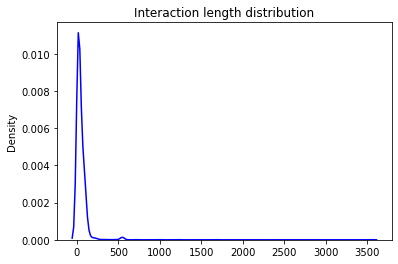

In [76]:
df_int = df[df.interacting]
lengths = list(pd.concat([df_int.w, df_int.h]))
print(f'median = {np.median(lengths)} nucleotides')
sns.kdeplot(lengths, color = 'blue')
plt.title(f'Interaction length distribution')
plt.show()

In [77]:
treshold = 25
perc = np.round(df_int[(df_int.w > treshold) & (df_int.h > treshold)].shape[0]/df_int.shape[0] * 100, 2)
print(f'If I take only the couples where both interaction regions are > {treshold} bp, I have the {perc}% of the dataset')

If I take only the couples where both interaction regions are > 25 bp, I have the 15.61% of the dataset


### CDS-CDS enrichment?

In [18]:
how = 'mario'

In [19]:
df = pd.read_csv(os.path.join(processed_files_dir, f'final_{how}_RANDOM.csv')) #final_df_RANDOM
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes_mario_ricseq.csv'))[['gene_id', 'CDS', 'UTR5', 'UTR3']]

In [20]:
def create_interactions_columns(df, df_genes):

    df = df.merge(df_genes, left_on = 'gene1', right_on = 'gene_id')
    df['where_x1'] = 'none'
    df.loc[(df.x1 < df.UTR5), 'where_x1'] = 'UTR5'
    df.loc[(df.x1 >= df.UTR5)&(df.x1 < df.CDS), 'where_x1'] = 'CDS'
    df.loc[(df.x1 >= df.CDS), 'where_x1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    
    df = df.merge(df_genes, left_on = 'gene2', right_on = 'gene_id')
    df['where_y1'] = 'none'
    df.loc[(df.y1 < df.UTR5), 'where_y1'] = 'UTR5'
    df.loc[(df.y1 >= df.UTR5)&(df.y1 < df.CDS), 'where_y1'] = 'CDS'
    df.loc[(df.y1 >= df.CDS), 'where_y1'] = 'UTR3'
    df = df.drop(['gene_id', 'UTR5', 'CDS', 'UTR3'], axis = 1)
    return df

def where_interacts(x):
    a,b = sorted([x.where_x1, x.where_y1])
    return a + '-' + b

df = create_interactions_columns(df, df_genes)
df['where'] = df.apply(where_interacts,axis = 1)

In [21]:
def plot_interaction_region(df):
    df_int, df_neg = df[df.interacting == True], df[df.interacting == False]
    
    # PLOT 
    categories = list(set(df_int['where'].value_counts().index).union(df_neg['where'].value_counts().index))

    neg = df_neg['where'].value_counts()
    neg = pd.Series([neg.get(key, 0) for key in categories], index=categories)

    pos = df_int['where'].value_counts()
    pos = pd.Series([pos.get(key, 0) for key in categories], index=categories)

    values1 = pos.values

    values2 = neg.values

    total1 = sum(values1)
    total2 = sum(values2)

    percentages1 = np.array([value / total1 * 100 for value in values1])
    percentages2 = np.array([value / total2 * 100 for value in values2])

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots(figsize=(12, 8))
    bar1 = ax.bar(index, percentages1, bar_width, label='Positive Distribution', color='skyblue')
    bar2 = ax.bar(index + bar_width, percentages2, bar_width, label='Negative Distribution', color='orange')

    ax.set_xlabel('Categories')
    ax.set_ylabel('Percentage')
    ax.set_title('Comparison of Two Distributions')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

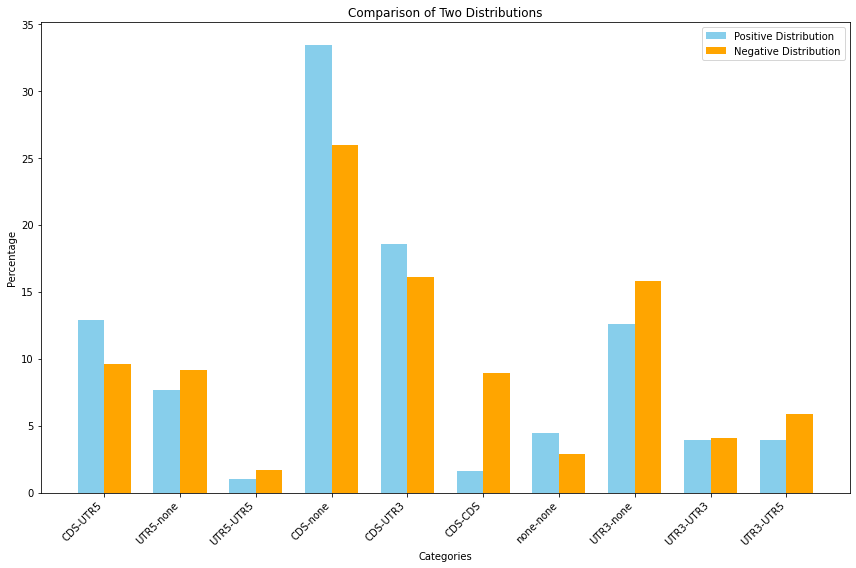

In [22]:
plot_interaction_region(df)